In [83]:
%pylab inline --no-import-all

# import numpy as np
from astropy.io import fits

from ctypes import c_float

from root_numpy import hist2array

Populating the interactive namespace from numpy and matplotlib


# First we need to generate the primary HDU

This contains the information about who wrote the file and the standards that it is written too.
The basic header has some information, we need to complete it to have the following

<pre>
SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
TELESCOP= 'VERITAS'            / Telescope                                      
LICENSE = '        '           / Copyright (c) 2018,The VERITAS Collaboration     
</pre>

In [84]:
st5File = "VEGAS/87658.med.ED.All.St5_Stereo.root"
eaFile = "VEGAS/EA_ua22stan_medPoint_050_ED_GRISU.root"
outfile = 'VEGAS/87658_DL3.fits'

In [85]:
hdu0 = fits.PrimaryHDU()
hdu0.header.set('TELESCOP', 'VERITAS', 'Telescope')
hdu0.header.set('LICENSE ', '', 'Copyright (c) 2018,The VERITAS Collaboration')
hdu0.header['COMMENT'] = "FITS (Flexible Image Transport System) format is defined in 'Astronomy"
hdu0.header['COMMENT'] = "and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H"

In [86]:
hdu0.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
TELESCOP= 'VERITAS '           / Telescope                                      
LICENSE = '' / Copyright (c) 2018,The VERITAS Collaboration                     
COMMENT FITS (Flexible Image Transport System) format is defined in 'Astronomy  
COMMENT and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H   

# Event Table 
The second hdu is the event table - this includes all of the events that pass the gamma/hadron selection cuts.

To load this we need to read in the VEGAS stage 5 file and select the keys of interest.  Then this can be saved into a table and then the hdu.  

We also need to put a lot of information into the header about the observations.

In [87]:
import ROOT
from ROOT import gSystem, TFile

In [88]:
if gSystem.Load("libVEGASCommon"):
    print "Problem loading VEGAS libraries - please check this before proceeding"

In [89]:
vegasFile = TFile(st5File, "read")
selectedEventsTree = vegasFile.Get("SelectedEvents/ShowerEventsTree")
runHeader = vegasFile.Get('RunHeader/VARunHeader')

In [90]:
runHeader.printRunHeader()

Run Number             : 87658
Run Start Time         : 2017-10-28 10:39:49.000000000
Run End Time           : 2017-10-28 11:09:49.000000000
Run Duration (min:sec) : 30:00 (this should be to the nearest second)
NominalLiveTime (seconds) : 1543.3
CutLiveTime (seconds) : 1543.3
Num Tels In Sub Array    : 4
Sub Array Telescopes used:T1 T2 T3 T4 
Num Samples Per Tel    : 16 16 16 16
Source information from DB:
	 Source : Crab
	 RA 	: 1.45968 [radians]
	 Dec 	: 0.384225 [radians]
	 epoch 	: 2000 
Run information as recorded to DB:
	 Weather 	: A-
	 Observing Mode : wobble
	 Source 	: Crab
	 OffsetRA 	: 0 [radians]
	 OffsetDec 	: 0.00872665 [radians]



In [91]:
selectedEventsTree.Print()

******************************************************************************
*Tree    :ShowerEventsTree: Cut VAShowerData Parameters                            *
*Entries :     2416 : Total =          830316 bytes  File  Size =     528757 *
*        :          : Tree compression factor =   1.57                       *
******************************************************************************
*Br    0 :S         : VAShowerData                                           *
*Entries :     2416 : Total  Size=     829862 bytes  File Size  =     527844 *
*Baskets :       53 : Basket Size=      16000 bytes  Compression=   1.57     *
*............................................................................*


## First we need to generate an array of the data

In [92]:
evNumArr = []
timeArr = []
raArr = []
decArr = []
azArr = []
altArr = []
energyArr = []
detXArr = []
detYArr = []

## Now we can populate the array from the ROOT file

Note: We also need to save some useful information for the average altitude, azimuth, RA and Dec.

I am not sure how best to do the average of the azimuth - I have ignored this for now ...

In [93]:
avAlt = []
avAz = []
avRA = []
avDec = []
avNoise = 4.2
for ev in selectedEventsTree:
    evNumArr.append(ev.S.fArrayEventNum)
    timeArr.append(float(ev.S.fTime.getDayNS())/1e9)
    raArr.append(np.rad2deg(ev.S.fDirectionRA_J2000_Rad))
    decArr.append(np.rad2deg(ev.S.fDirectionDec_J2000_Rad))
    azArr.append(np.rad2deg(ev.S.fDirectionAzimuth_Rad))
    altArr.append(np.rad2deg(ev.S.fDirectionElevation_Rad))
    energyArr.append(ev.S.fEnergy_GeV / 1000.)
    detXArr.append(ev.S.fDirectionXCamPlane_Deg)
    detYArr.append(ev.S.fDirectionYCamPlane_Deg)
    
    avAlt.append(ev.S.fArrayTrackingElevation_Deg)
    avAz.append(ev.S.fArrayTrackingAzimuth_Deg)
    avRA.append(ev.S.fArrayTrackingRA_J2000_Rad)
    avDec.append(ev.S.fArrayTrackingDec_J2000_Rad)
    
#     avNoise += ev.S.f
    
# numEv = selectedEventsTree.GetEntriesFast()
# print avAlt, avAz, avRA, avDec

avAlt = np.mean(avAlt)
avAz = np.mean(avAz)
avRA = np.rad2deg(np.mean(avRA))
avDec = np.rad2deg(np.mean(avDec))
# avNoise = avNoise/numEv

# print avAlt, avAz, avRA, avDec

## Now we need to generate an HDU

In [94]:
hdu1 = fits.BinTableHDU.from_columns([
    fits.Column(name='EVENT_ID', format='1J', array=evNumArr), 
    fits.Column(name='TIME', format='1D', array=timeArr, unit="s"), 
    fits.Column(name='RA', format='1E', array=raArr, unit = "deg"), 
    fits.Column(name='DEC', format='1E', array=decArr, unit = "deg"), 
    fits.Column(name='ALT', format='1E', array=altArr, unit = "deg"), 
    fits.Column(name='AZ', format='1E', array=azArr, unit = "deg"), 
    fits.Column(name='ENERGY', format='1E', array=energyArr, unit = "TeV"), 
    fits.Column(name='DETX', format='1E', array=detXArr, unit = "deg"), 
    fits.Column(name='DETY', format='1E', array=detYArr, unit = "deg")
])
hdu1.name = "EVENTS"

## Header Information

In [95]:
def decodeConfigMask(mask=15):
    '''Decode the telescope config mask to find the telescpes in the array'''
    tels = []
    if mask >= 8:
        tels.append(4)
        mask -= 8
    if mask >= 4:
        tels.append(3)
        mask -= 4
    if mask >= 2:
        tels.append(2)
        mask -= 2
    if mask >= 1:
        tels.append(1)
        mask -= 1
    return sorted(tels)


def produceTelList(mask):
    '''Convert the list of telescopes into a string for FITS header'''
    telList = ""
    for tel in decodeConfigMask(mask):
        telList += "T" + str(tel) + ","
    return telList

In [96]:
hdu1.header.set('OBS_ID  ', runHeader.getRunNumber(), 'Run Number')
hdu1.header.set('TELESCOP', 'VERITAS', 'Data from VERITAS')

startTime = runHeader.getStartTime()
endTime = runHeader.getEndTime()

startTime_s = float(startTime.getDayNS()) / 1e9
endTime_s = float(endTime.getDayNS()) / 1e9
hdu1.header.set('DATE-OBS',
                startTime.getString().split()[0],
                'start date (UTC) of obs yy-mm-dd')
hdu1.header.set('TIME-OBS',
                startTime.getString().split()[1],
                'start time (UTC) of obs hh-mm-ss')
hdu1.header.set('DATE-END',
                endTime.getString().split()[0],
                'end date (UTC) of obs yy-mm-dd')
hdu1.header.set('TIME-END',
                endTime.getString().split()[1],
                'end time (UTC) of obs hh-mm-ss')

hdu1.header.set('TSTART  ',
                startTime_s,
                'mission time of start of obs [s]')
hdu1.header.set('TSTOP   ',
                endTime_s,
                'mission time of end of obs [s]')
hdu1.header.set('MJDREFI ',
                int(startTime.getMJDInt()), 'int part of reference MJD [days]')
hdu1.header.set('MJDREFF ', 0., 'fractional part of reference MJD [days]')

hdu1.header.set('TIMEUNIT', 's', 'time unit is seconds since MET start')
hdu1.header.set('TIMESYS ', 'utc', 'time scale is UTC')
hdu1.header.set('TIMEREF ', 'local', 'local time reference')

hdu1.header.set('ONTIME  ', 
                endTime_s - startTime_s,
                'time on target (including deadtime)')
hdu1.header.set('LIVETIME', runHeader.pfRunDetails.fRunNominalLiveTimeSeconds,
                '(dead=ONTIME-LIVETIME) [s] ')
hdu1.header.set('DEADC   ', runHeader.getLiveTimeFrac(),
                'average deadtime fraction [] ')

hdu1.header.set('OBJECT  ', runHeader.getSourceId(), 'observed object')

hdu1.header.set('RA_PNT  ', avRA, 'observation position RA [deg]')
hdu1.header.set('DEC_PNT ', avDec, 'observation position DEC [deg]')
hdu1.header.set('ALT_PNT ', avAlt, 'average altitude of pointing [deg]')
hdu1.header.set('AZ_PNT  ', 0., 'average azimuth of pointing [deg]')

hdu1.header.set('RA_OBJ  ',
                np.rad2deg(runHeader.getSourceRA()),
                'observation position RA [deg]')
hdu1.header.set('DEC_OBJ ',
                np.rad2deg(runHeader.getSourceDec()),
                'observation position DEC [deg]')

# get the list of telescopes that participate in the event
hdu1.header.set('TELLIST',
                produceTelList(runHeader.fRunInfo.fConfigMask),
                'comma-separated list of tel IDs')
hdu1.header.set('N_TELS', runHeader.pfRunDetails.fTels,
                'number of telescopes in event list')

# other info - weather? pointing mode

hdu1.header.set('EUNIT   ', 'TeV', 'energy unit')
hdu1.header.set('GEOLAT  ', 31.6751, 'longitude of array center [deg]')
hdu1.header.set('GEOLON  ', -110.952, 'latitude of array center [deg]')
hdu1.header.set('ALTITUDE', 1268, 'altitude of array center [m]')

# What are these for? - May note be needed, leave out for now.
hdu1.header.set('DSTYP1', 'TIME    ', 'Data selection type')
hdu1.header.set('DSUNI1', 's       ', 'Data selection unit')
hdu1.header.set('DSVAL1', 'TABLE   ', 'Data selection value')
hdu1.header.set('DSREF1', ':GTI    ', 'Data selection reference')
hdu1.header.set('DSTYP2', 'POS(RA,DEC)', 'Data selection type')
hdu1.header.set('DSUNI2', 'deg     ', 'Data selection unit')
hdu1.header.set('DSVAL2', 'CIRCLE(83.63,22.01,5)', 'Data selection value')
hdu1.header.set('DSTYP3', 'ENERGY  ', 'Data selection type')
hdu1.header.set('DSUNI3', 'TeV     ', 'Data selection unit')
hdu1.header.set('DSVAL3', '0.05:100', 'Data selection value')
hdu1.header.set('NDSKEYS', '3       ', 'Number of data selections')
hdu1.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   40 / length of dimension 1                          
NAXIS2  =                 2416 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    9 / number of table fields                         
TTYPE1  = 'EVENT_ID'                                                            
TFORM1  = '1J      '                                                            
TTYPE2  = 'TIME    '                                                            
TFORM2  = '1D      '                                                            
TUNIT2  = 's       '        

using DB start/end time instead of VBF time to calculate fractional live time.


# Good Time Intervals (GTI)

In [97]:
goodTimeStart = []
goodTimeStop = []

goodTimeStart.append(startTime_s)
goodTimeStop.append(endTime_s)

In [98]:
# do we record the unit in this table as well? (it is in seconds)

hdu2 = fits.BinTableHDU.from_columns([
    fits.Column(name='START', format='1D', array=goodTimeStart), 
    fits.Column(name='STOP', format='1D', array=goodTimeStop)
])
hdu2.name = "GTI"
hdu2.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   16 / length of dimension 1                          
NAXIS2  =                    1 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    2 / number of table fields                         
TTYPE1  = 'START   '                                                            
TFORM1  = '1D      '                                                            
TTYPE2  = 'STOP    '                                                            
TFORM2  = '1D      '                                                            
EXTNAME = 'GTI     '        

# Effective Area

Question - what do we need to do about sim vs real spectral index?

In [99]:
if gSystem.Load("libVEGASStage6"):
    print "Problem loading VEGAS libraries - please check this before proceeding"

In [100]:
from ROOT import TGraphAsymmErrors
from ROOT import VARootIO, VAEffectiveAreaManager, VAEASimpleParameterData

### First we need to load the EA file

In [101]:
effectiveAreaIO = VARootIO(eaFile, True)
effectiveAreaIO.loadTheRootFile()

True

### Then we need to load the Effective Area

In [102]:
effectiveAreaManager = VAEffectiveAreaManager()
effectiveAreaManager.loadEffectiveAreas(effectiveAreaIO)
effectiveAreaManager.setUseReconstructedEnergy(False)

Updating Modified Effective Areas with Standard algorithm...
EA: Function parameters used for Modified Eff Areas and fit seeds:  1.4e-07 -2.5 1
EA: fitFunction initialized [0]*pow(x/[2],[1])
Effective Area file has MEA's made using a RealSpectralIndexof: -2.5
***MEA's for this run will be made as needed using 
***the function and parameters above.  If they do not match stage6 results,
***vaStage6 should be re-run with the new parameters.
***You should iterate until they agree.

#############################################
  Getting tree with EA parameters - please 
  check that dimensions and values are what 
  you expected
Number of parameters:  3
Azimuth:  0 45 90 135 180 225 270 315 
Zenith:  0 20 30 35 40 45 50 55 60 65 
Noise:  4.24 5.21 6 6.68 7.27 7.82 8.33 9.2 10.19 11.17 12.17 
#############################################



### Set the EA parameters

In [103]:
effectiveAreaParameters = VAEASimpleParameterData()
effectiveAreaParameters.fAzimuth = (avAz)
effectiveAreaParameters.fZenith = (90. - avAlt)
effectiveAreaParameters.fNoise = 4.2 # this still needs to be worked out
effectiveAreaParameters.fOffset = 0.5 # itterate over this in steps? (0.5deg as for sims?)


print avAlt, effectiveAreaParameters.fZenith
# convert to vector of parameters since this is required for a number of steps
effectiveAreaParameters = effectiveAreaManager.getVectorParamsFromSimpleParameterData(effectiveAreaParameters)


79.3884155482 10.6115846634


### Get the EA

In [104]:
effectiveArea = effectiveAreaManager.getEffectiveAreaCurve(effectiveAreaParameters)

### Lets Check by Plotting

In [105]:
x, y, ye = [], [], []
for i in range(effectiveArea.GetN()):
    tmpX, tmpY = ROOT.Double(0), ROOT.Double(0)
    effectiveArea.GetPoint(i, tmpX, tmpY)
    ye.append(effectiveArea.GetErrorY(i))
    effectiveArea.GetErrorX
    x.append(tmpX)
    y.append(tmpY)
        
x = np.array(x)
y = np.array(y)
ye = np.array(ye)

[]

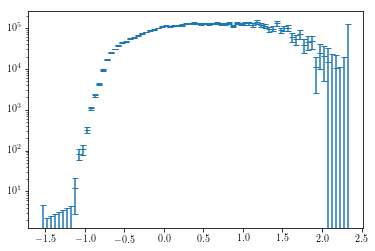

In [106]:
plt.errorbar(x, y, yerr = ye, ls = "", marker = "_")
plt.semilogy()

In [107]:
energyLow = np.power(10, x - (x[1] - x[0])/2.)
energyHigh = np.power(10, x + (x[1] - x[0])/2.)
thetaLow = [0.0, 1.0]
thetaHigh = [1.0, 2.0]
# ea = np.vstack((y, y))
ea = [y,y]
minEnergy , maxEnergy = c_float(), c_float()
effectiveAreaManager.getSafeEnergyRange(effectiveAreaParameters, 0.5, minEnergy, maxEnergy)

True

+++ EA: Calculating safe energy range using E_EnergyEAPrecision method
+++ EA: min safe energy Emin = 149.624,   EAerr = 8.5095%
+++ EA: max safe energy Emax = 37583.7,   EAerr = 19.7062%


In [108]:
np.shape(ea)

(2, 78)

In [109]:
x = np.array([(energyLow, energyHigh, thetaLow, thetaHigh, ea)], 
             dtype=[('ENERG_LO', '>f4', np.shape(energyLow)), 
                    ('ENERG_HI', '>f4', np.shape(energyHigh)), 
                    ('THETA_LO', '>f4', np.shape(thetaLow)), 
                    ('THETA_HI', '>f4', np.shape(thetaHigh)), 
                    ('EFFAREA', '>f4', np.shape(ea))])

In [110]:
hdu3 = fits.BinTableHDU(data=x)
hdu3.name = "EFFECTIVE AREA"

hdu3.header.set('TUNIT1 ', 'TeV', "")
hdu3.header.set('TUNIT2 ', 'TeV', "")
hdu3.header.set('TUNIT3 ', 'deg', "")
hdu3.header.set('TUNIT4 ', 'deg', "")
hdu3.header.set('TUNIT5 ', 'm^2', "")

hdu3.header.set('HDUCLASS', 'GADF',
                'FITS file following the GADF data format.')
hdu3.header.set('HDUCLAS1', 'RESPONSE', 'HDU class')
hdu3.header.set('HDUCLAS2', 'EFF_AREA', 'HDU class')
hdu3.header.set('HDUCLAS3', 'POINT-LIKE', 'HDU class')
hdu3.header.set('HDUCLAS4', 'AEFF_2D', 'HDU class')
hdu3.header.set('LO_THRES', minEnergy.value/1000.,
                'Low energy threshold of validity [TeV]')
hdu3.header.set('HI_THRES', maxEnergy.value/1000.,
                'High energy threshold of validity [TeV]')
hdu3.header.set('RAD_MAX ', 0.1, 'Direction cut applied [deg]')

hdu3.columns

ColDefs(
    name = 'ENERG_LO'; format = '78E'
    name = 'ENERG_HI'; format = '78E'
    name = 'THETA_LO'; format = '2E'
    name = 'THETA_HI'; format = '2E'
    name = 'EFFAREA'; format = '156E'; dim = '(78,2)'
)

In [111]:
hdu3.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1264 / length of dimension 1                          
NAXIS2  =                    1 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    5 / number of table fields                         
TTYPE1  = 'ENERG_LO'                                                            
TFORM1  = '78E     '                                                            
TTYPE2  = 'ENERG_HI'                                                            
TFORM2  = '78E     '                                                            
TTYPE3  = 'THETA_LO'        

# Migration Matrix
We want to get pfEnergy_Rec_VS_MC_2D for the correct parameters.

This could be done with a getter within VEGAS - lets try that first!

In [112]:
a, e = hist2array(effectiveAreaManager.getEnergyBias2D(effectiveAreaParameters), return_edges=True)

In [113]:
eLow = np.power(10, [e[0][:-1]])[0]
eHigh = np.power(10, [e[0][1:]])[0]

bLow = np.power(10, [e[1][:-1]])[0]
bHigh = np.power(10, [e[1][1:]])[0]

ac = []
for aa in a:
    if np.sum(aa) > 0:
        ab = aa / np.sum(aa*(bHigh - bLow))
    else:
        ab = aa
    try:
        ac = np.vstack((ac, ab))
    except:
        ac = ab
        
ac = ac.transpose()

In [114]:
eLow

array([  1.00000000e-02,   1.12201845e-02,   1.25892541e-02,
         1.41253754e-02,   1.58489319e-02,   1.77827941e-02,
         1.99526231e-02,   2.23872114e-02,   2.51188643e-02,
         2.81838293e-02,   3.16227766e-02,   3.54813389e-02,
         3.98107171e-02,   4.46683592e-02,   5.01187234e-02,
         5.62341325e-02,   6.30957344e-02,   7.07945784e-02,
         7.94328235e-02,   8.91250938e-02,   1.00000000e-01,
         1.12201845e-01,   1.25892541e-01,   1.41253754e-01,
         1.58489319e-01,   1.77827941e-01,   1.99526231e-01,
         2.23872114e-01,   2.51188643e-01,   2.81838293e-01,
         3.16227766e-01,   3.54813389e-01,   3.98107171e-01,
         4.46683592e-01,   5.01187234e-01,   5.62341325e-01,
         6.30957344e-01,   7.07945784e-01,   7.94328235e-01,
         8.91250938e-01,   1.00000000e+00,   1.12201845e+00,
         1.25892541e+00,   1.41253754e+00,   1.58489319e+00,
         1.77827941e+00,   1.99526231e+00,   2.23872114e+00,
         2.51188643e+00,

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


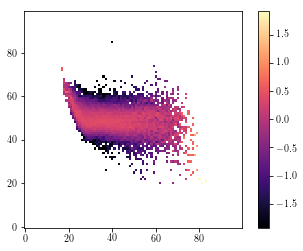

In [115]:
plt.imshow(np.log10(ac))
plt.colorbar()

In [116]:
x = np.array([(eLow, eHigh, bLow, bHigh, [0, 1.0], [1.0, 2.0], [ac, ac])], 
             dtype=[('ETRUE_LO', '>f4', (len(eLow),)), 
                    ('ETRUE_HI', '>f4', (len(eHigh),)), 
                    ('MIGRA_LO', '>f4', (len(bLow),)), 
                    ('MIGRA_HI', '>f4', (len(bLow),)), 
                    ('THETA_LO', '>f4', (2,)), 
                    ('THETA_HI', '>f4', (2,)), 
                    ('MATRIX', '>f4', (2, np.shape(ac)[0], np.shape(ac)[1]))])

hdu4 = fits.BinTableHDU(data=x)
hdu4.name = "ENERGY DISPERSION"

hdu4.header.set('TUNIT1 ', 'TeV', "")
hdu4.header.set('TUNIT2 ', 'TeV', "")
hdu4.header.set('TUNIT5 ', 'deg', "")
hdu4.header.set('TUNIT6 ', 'deg', "")
# hdu3.header.set('TUNIT5 ', 'm^2', "")

hdu4.header.set('HDUCLASS', 'GADF',
                'FITS file following the GADF data format.')
hdu4.header.set('HDUCLAS1', 'RESPONSE', 'HDU class')
hdu4.header.set('HDUCLAS2', 'EDISP', 'HDU class')
hdu4.header.set('HDUCLAS3', 'POINT-LIKE', 'HDU class')
hdu4.header.set('HDUCLAS4', 'EDISP_2D', 'HDU class')
hdu4.header.set('LO_THRES', minEnergy.value/1000.,
                'Low energy threshold of validity [TeV]')
hdu4.header.set('HI_THRES', maxEnergy.value/1000.,
                'High energy threshold of validity [TeV]')
hdu4.header.set('RAD_MAX ', 0.1, 'Direction cut applied [deg]')

hdu4.columns

ColDefs(
    name = 'ETRUE_LO'; format = '100E'
    name = 'ETRUE_HI'; format = '100E'
    name = 'MIGRA_LO'; format = '100E'
    name = 'MIGRA_HI'; format = '100E'
    name = 'THETA_LO'; format = '2E'
    name = 'THETA_HI'; format = '2E'
    name = 'MATRIX'; format = '20000E'; dim = '(100,100,2)'
)

In [117]:
hdu4.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                81616 / length of dimension 1                          
NAXIS2  =                    1 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    7 / number of table fields                         
TTYPE1  = 'ETRUE_LO'                                                            
TFORM1  = '100E    '                                                            
TTYPE2  = 'ETRUE_HI'                                                            
TFORM2  = '100E    '                                                            
TTYPE3  = 'MIGRA_LO'        

# Fudge background in

In [118]:
magicDL3 = fits.open("MAGIC/CrabNebula_sample1_fine_binning.fits")

# Write FITS file

In [119]:
hdulist = fits.HDUList([hdu0, hdu1, hdu2, hdu3, hdu4])
hdulist.writeto(outfile, overwrite=True)


In [120]:
hdulist.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   ()      
  1  EVENTS        1 BinTableHDU     75   2416R x 9C   ['1J', '1D', '1E', '1E', '1E', '1E', '1E', '1E', '1E']   
  2  GTI           1 BinTableHDU     13   1R x 2C   ['1D', '1D']   
  3  EFFECTIVE AREA    1 BinTableHDU     33   1R x 5C   ['78E', '78E', '2E', '2E', '156E']   
  4  ENERGY DISPERSION    1 BinTableHDU     36   1R x 7C   ['100E', '100E', '100E', '100E', '2E', '2E', '20000E']   
